In [483]:
%pip install tensorflow numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [484]:
import torch
import numpy as np
from torch.utils.data import Dataset
import os
import random

In [485]:
class GaitDataset(Dataset):
    def __init__(self, folder_path, crop_size, noise_level, no_crops, name):
        self.data = []
        self.labels = []
        self.crop_size = crop_size
        self.noise_level = noise_level

        # Second pass: Read data, augment, normalize, and store
        for filename in os.listdir(folder_path):
            if filename.endswith(".txt"):
                label_name = filename.split("_")[0]
                if label_name == name:
                    label = 1
                else:
                    label = 0
                file_path = os.path.join(folder_path, filename)
                with open(file_path, "r") as file:
                    content = np.loadtxt(file, delimiter=",")

                    for _ in range(no_crops):
                        cropped_content = self.random_crop(content, self.crop_size)
                        noisy_content = self.add_noise(
                            cropped_content, self.noise_level
                        )
                        sample_mean = noisy_content.mean(axis=0)
                        sample_std = noisy_content.std(axis=0)
                        normalized_content = (noisy_content - sample_mean) / sample_std

                        self.data.append(normalized_content)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample_tensor = torch.from_numpy(sample).float().transpose(0, 1)
        return sample_tensor, label

    def random_crop(self, sample, crop_size):
        if len(sample) > crop_size:
            start = random.randint(0, len(sample) - crop_size)
            return sample[start : start + crop_size]
        return sample

    def add_noise(self, sample, noise_level):
        noise = np.random.normal(0, noise_level, sample.shape)
        return sample + noise


# Usage
folder_path = "data"
crop_size = 400  # Example crop size
no_crops = 50  # number of crops per sample
noise_level = 0.01  # Example noise level
dataset_nate = GaitDataset(folder_path, crop_size, noise_level, no_crops, "nate")
dataset_hersh = GaitDataset(folder_path, crop_size, noise_level, no_crops, "hersh")
dataset_ryan = GaitDataset(folder_path, crop_size, noise_level, no_crops, "ryan")

In [486]:
from torch.utils.data import random_split

# Assuming dataset is an instance of GaitDataset
total_size = len(dataset_nate)
train_size = int(0.7 * total_size)
val_size = test_size = (total_size - train_size) // 2

train_dataset_nate, val_dataset_nate, test_dataset_nate = random_split(
    dataset_nate, [train_size, val_size, test_size]
)

train_dataset_hersh, val_dataset_hersh, test_dataset_hersh = random_split(
    dataset_hersh, [train_size, val_size, test_size]
)

train_dataset_ryan, val_dataset_ryan, test_dataset_ryan = random_split(
    dataset_ryan, [train_size, val_size, test_size]
)

In [487]:
from torch.utils.data import DataLoader

batch_size = 32  # You can modify this based on your requirements and GPU memory

train_loader_nate = DataLoader(train_dataset_nate, batch_size=batch_size, shuffle=True)
val_loader_nate = DataLoader(val_dataset_nate, batch_size=batch_size, shuffle=False)
test_loader_nate = DataLoader(test_dataset_nate, batch_size=batch_size, shuffle=False)

train_loader_hersh = DataLoader(train_dataset_hersh, batch_size=batch_size, shuffle=True)
val_loader_hersh = DataLoader(val_dataset_hersh, batch_size=batch_size, shuffle=False)
test_loader_hersh = DataLoader(test_dataset_hersh, batch_size=batch_size, shuffle=False)

train_loader_ryan = DataLoader(train_dataset_ryan, batch_size=batch_size, shuffle=True)
val_loader_ryan = DataLoader(val_dataset_ryan, batch_size=batch_size, shuffle=False)
test_loader_ryan = DataLoader(test_dataset_ryan, batch_size=batch_size, shuffle=False)

In [488]:
import torch.nn as nn
import torch.nn.functional as F


class Gait1DCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(Gait1DCNN, self).__init__()
        # Input shape: [batch_size, 6, 400]
        self.conv1 = nn.Conv1d(
            in_channels=6, out_channels=64, kernel_size=3, stride=1, padding=1
        )
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the features after the convolution and pooling layers
        # Assuming input length is 500 and you apply pooling twice
        conv_output_size = 400 // 2 // 2
        self.fc1 = nn.Linear(128 * conv_output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the output for the dense layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Number of classes
num_classes = 2


In [489]:
def train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Validation Loss: {avg_val_loss:.4f}, "
            f"Validation Accuracy: {val_accuracy:.2f}%"
        )

    return train_losses, val_losses, val_accuracies

In [490]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [491]:
import matplotlib.pyplot as plt


def plot_metrics(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

Training model for nate
Epoch [1/10], Train Loss: 0.2534, Validation Loss: 0.0050, Validation Accuracy: 100.00%
Epoch [2/10], Train Loss: 0.0017, Validation Loss: 0.0010, Validation Accuracy: 100.00%
Epoch [3/10], Train Loss: 0.0005, Validation Loss: 0.0006, Validation Accuracy: 100.00%
Epoch [4/10], Train Loss: 0.0002, Validation Loss: 0.0004, Validation Accuracy: 100.00%
Epoch [5/10], Train Loss: 0.0002, Validation Loss: 0.0003, Validation Accuracy: 100.00%
Epoch [6/10], Train Loss: 0.0001, Validation Loss: 0.0002, Validation Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0001, Validation Accuracy: 100.00%
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0001, Validation Accuracy: 100.00%


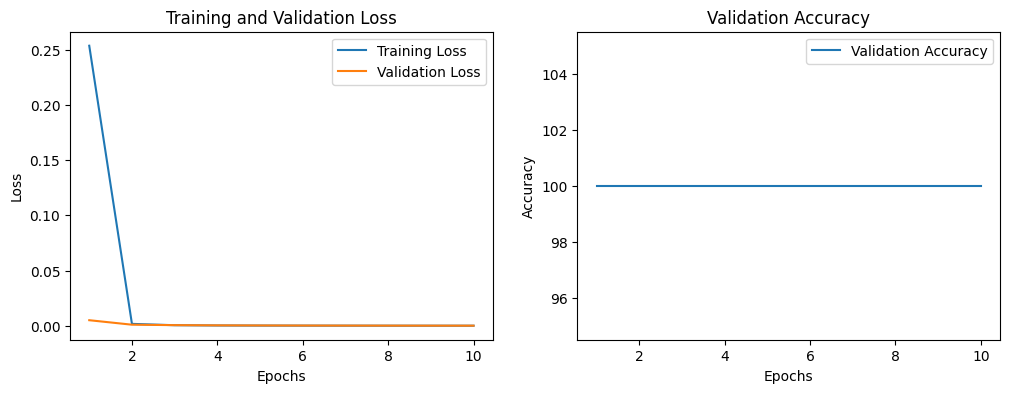

Test Accuracy: 100.00%
Training model for ryan
Epoch [1/10], Train Loss: 0.3080, Validation Loss: 0.0100, Validation Accuracy: 99.78%
Epoch [2/10], Train Loss: 0.0017, Validation Loss: 0.0013, Validation Accuracy: 100.00%
Epoch [3/10], Train Loss: 0.0005, Validation Loss: 0.0009, Validation Accuracy: 100.00%
Epoch [4/10], Train Loss: 0.0003, Validation Loss: 0.0007, Validation Accuracy: 100.00%
Epoch [5/10], Train Loss: 0.0002, Validation Loss: 0.0004, Validation Accuracy: 100.00%
Epoch [6/10], Train Loss: 0.0001, Validation Loss: 0.0003, Validation Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.0001, Validation Loss: 0.0002, Validation Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0001, Validation Loss: 0.0003, Validation Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.0001, Validation Loss: 0.0002, Validation Accuracy: 100.00%
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0002, Validation Accuracy: 100.00%


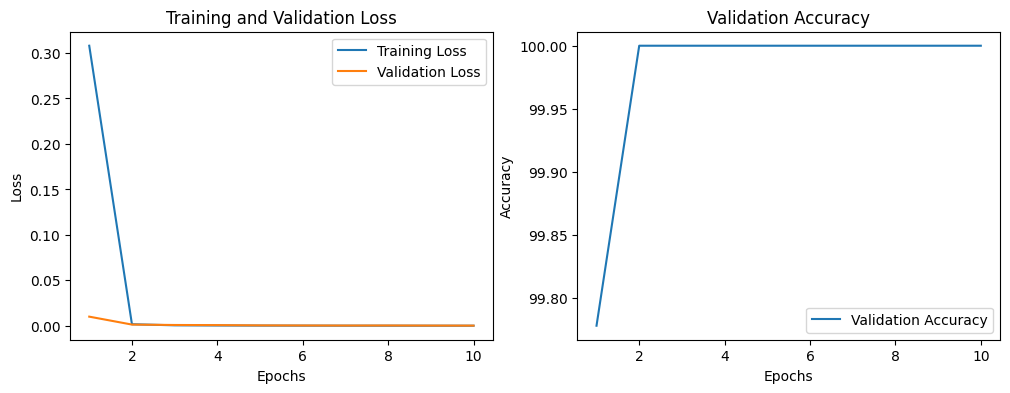

Test Accuracy: 100.00%
Training model for hersh
Epoch [1/10], Train Loss: 0.3534, Validation Loss: 0.0013, Validation Accuracy: 100.00%
Epoch [2/10], Train Loss: 0.0004, Validation Loss: 0.0002, Validation Accuracy: 100.00%
Epoch [3/10], Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 100.00%
Epoch [4/10], Train Loss: 0.0001, Validation Loss: 0.0001, Validation Accuracy: 100.00%
Epoch [5/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [6/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%
Epoch [10/10], Train Loss: 0.0000, Validation Loss: 0.0000, Validation Accuracy: 100.00%


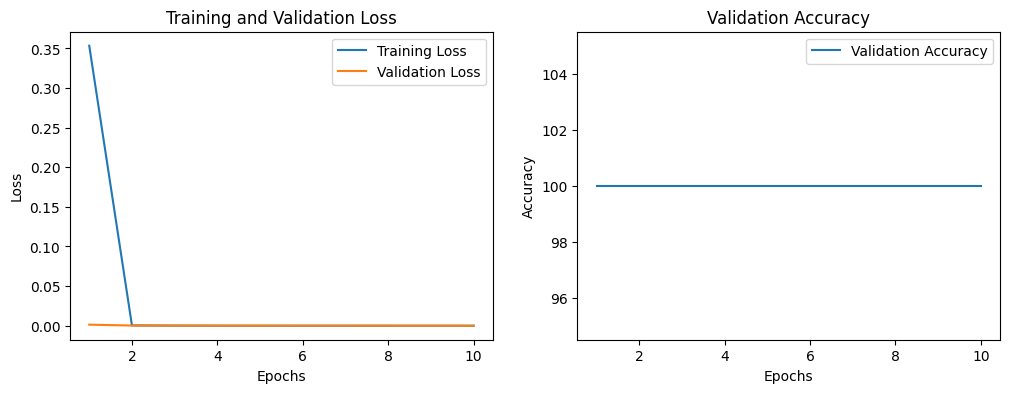

Test Accuracy: 100.00%


In [492]:
import torch.optim as optim

# Model Initialization
model_nate = Gait1DCNN(num_classes=2)
model_hersh = Gait1DCNN(num_classes=2)
model_ryan = Gait1DCNN(num_classes=2)

# Loss and Optimizer
for model, train_loader, val_loader, test_loader, name in [
    (model_nate, train_loader_nate, val_loader_nate, test_loader_nate, "nate"),
    (model_ryan, train_loader_ryan, val_loader_ryan, test_loader_ryan, "ryan"),
    (model_hersh, train_loader_hersh, val_loader_hersh, test_loader_hersh, "hersh"),
]:
    print(f"Training model for {name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Parameters
    num_epochs = 10

    # Training and Validating the Model, and Plotting the Metrics
    train_losses, val_losses, val_accuracies = train_and_validate(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )
    plot_metrics(train_losses, val_losses, val_accuracies)

    # Testing the Model
    test(model, test_loader)

In [493]:
# Save the model
torch.save(model_hersh, "1D_CNN_model_hersh.pth")
torch.save(model_ryan, "1D_CNN_model_ryan.pth")
torch.save(model_nate, "1D_CNN_model_nate.pth")

In [494]:
# model = torch.load("1D_CNN_model.pth")
# model.eval()  # Set the model to evaluation mode

In [495]:
def preprocess_data(sample, crop_size, noise_level):
    # Normalize the sample
    sample_mean = sample.mean(axis=0)
    sample_std = sample.std(axis=0)
    sample = (sample - sample_mean) / sample_std

    # Random cropping
    if sample.shape[0] > crop_size:
        start = np.random.randint(0, sample.shape[0] - crop_size)
        sample = sample[start : start + crop_size, :]
    else:
        # If the sample is shorter than crop_size, you might want to pad it or handle it differently
        pass

    # Adding noise
    noise = np.random.normal(0, noise_level, sample.shape)
    sample = sample + noise

    # Reshape and convert to PyTorch tensor
    sample_tensor = torch.from_numpy(sample).float().transpose(0, 1).unsqueeze(0)
    return sample_tensor

In [504]:
# Define preprocessing parameters
crop_size = 400  # Example crop size, adjust to your needs
noise_level = 0.01  # Example noise level


def predict(model, sample):
    with torch.no_grad():  # Ensure gradients are not computed in inference mode
        preprocessed_sample = preprocess_data(sample, crop_size, noise_level)
        outputs = model(preprocessed_sample)
        print(outputs)
        _, predicted = torch.max(outputs, 1)
        return predicted.item()  # or return outputs for probabilistic interpretation


# Example usage
sample = np.loadtxt("data/ryan_4.txt", delimiter=",")  # Replace with your actual data
prediction = predict(model_nate, sample)
print(f"Predicted class: {prediction}")
prediction = predict(model_hersh, sample)
print(f"Predicted class: {prediction}")
prediction = predict(model_ryan, sample)
print(f"Predicted class: {prediction}")

tensor([[ 5.1066, -6.9996]])
Predicted class: 0
tensor([[-6.4650,  6.8752]])
Predicted class: 1
tensor([[11.8881, -8.0933]])
Predicted class: 0
